# Showcasing the results
1. Estimation performance
2. Hypothesis testing performance

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

import matplotlib.pyplot as plt
import numpy as np
import scipy
import json
import pandas as pd
import seaborn as sns
import os
import admix
import scipy.stats

In [2]:
def estimate_rg(est, est_var):
    """
    Estimate the ratio of genetic correlation.
    est: (3, ) numpy array
    est_var (3, 3) variance-covariance matrix
    """
    x, y = est[0], est[1]
    rg = y / x
    # grad = [-y / x^2, 1 / x]
    grad = np.array([-y / (x ** 2), 1 / x])

    def quad_form(x, A):
        return np.dot(np.dot(x.T, A), x)

    return rg, quad_form(grad, est_var[0:2, 0:2])

# Plot GCTA

In [3]:
df_plot = []

for hsq in [0.1, 0.25, 0.5]:
    for pcausal in [0.00001, 0.0001, 0.001, 0.01]:
        for cor in [0.9, 0.95, 1.0]:
            for hermodel in ["mafukb"]:
                for sim_i in range(0, 500):
                    f_name = (
                        f"out/gcta-estimate/hsq-{hsq}-pcausal-{np.format_float_positional(pcausal)}-cor-{cor}"
                        + f"-hermodel-{hermodel}.sim_{sim_i}"
                    )
                    if not os.path.exists(f_name + ".hsq"):
                        continue
                    try:
                        est = admix.tools.gcta.read_reml(f_name)
                        rg, rg_var = estimate_rg(
                            est["est"].Variance.values, est["varcov"].values
                        )
                        rg_stderr = np.sqrt(rg_var)

                        # results from likelihood ratio test
                        reduced_est = admix.tools.gcta.read_reml(f_name + ".reduced")
                        pval_lrt = scipy.stats.chi2.sf(
                            2 * (est["loglik"] - reduced_est["loglik"]), 1
                        )
                        pval_delta = scipy.stats.norm.cdf((rg - 1) / rg_stderr)
                        df_plot.append(
                            est["est"].Variance.values.tolist()
                            + [
                                hsq,
                                cor,
                                pcausal,
                                hermodel,
                                rg,
                                rg_stderr,
                                pval_lrt,
                                pval_delta,
                                sim_i,
                            ]
                        )
                    except ValueError:
                        print("Invalid value!")
df_plot = pd.DataFrame(
    df_plot,
    columns=[
        "estimated_var_g",
        "estimated_rho",
        "estimated_var_e",
        "hsq",
        "cor",
        "pcausal",
        "hermodel",
        "estimated_ratio",
        "estimated_ratio_stderr",
        "pval_lrt",
        "pval_delta",
        "sim_i",
    ],
)

Invalid value!
Invalid value!


In [3]:
# df_plot.to_csv("results/raw.csv", index=False)
df_plot = pd.read_csv("results/raw.csv")

In [36]:
df_summary = (
    df_plot.groupby(["hsq", "cor", "pcausal"])
    .agg(
        {
            "estimated_ratio": ["mean", "std"],
            "estimated_ratio_stderr": "median",
            "pval_lrt": lambda x: np.mean(x < 0.05),
            "pval_delta": lambda x: np.mean(x < 0.05),
        }
    )
    .reset_index()
)

In [38]:
df_summary[df_summary.cor == 1.0]

hsq  cor  pcausal estimated_ratio           estimated_ratio_stderr  \
                                  mean       mad                 median   
8   0.10  1.0  0.00001        0.990419  0.072179               0.066732   
9   0.10  1.0  0.00010        0.990344  0.064731               0.069478   
10  0.10  1.0  0.00100        0.994026  0.062517               0.067838   
11  0.10  1.0  0.01000        0.987678  0.058964               0.069333   
20  0.25  1.0  0.00001        0.990149  0.049538               0.038225   
21  0.25  1.0  0.00010        0.997881  0.034677               0.037125   
22  0.25  1.0  0.00100        1.000877  0.030434               0.036848   
23  0.25  1.0  0.01000        1.000807  0.030365               0.037052   
32  0.50  1.0  0.00001        0.994960  0.041416               0.024554   
33  0.50  1.0  0.00010        0.999557  0.022465               0.024530   
34  0.50  1.0  0.00100        0.999824  0.019538               0.024680   
35  0.50  1.0  0.01000        0.999170  0.019396               0.024773   

    pval_lrt pval_delta  
    <lambda>   <lambda>  
8   0.092555   0.020121  
9   0.056338   0.002012  
10  0.064386   0.004024  
11  0.054217   0.008032  
20  0.226000   0.116000  
21  0.086000   0.036000  
22  0.064000   0.028000  
23  0.054000   0.020000  
32  0.350000   0.188000  
33  0.088000   0.046000  
34  0.056000   0.040000  
35  0.056000   0.036000

In [18]:
df_summary[df_summary.cor == 1.0]

hsq  cor  pcausal estimated_ratio           estimated_ratio_stderr  \
                                  mean       std                   mean   
8   0.10  1.0  0.00001        0.990419  0.093819               0.078055   
9   0.10  1.0  0.00010        0.990344  0.083561               0.077202   
10  0.10  1.0  0.00100        0.994026  0.083090               0.075354   
11  0.10  1.0  0.01000        0.987678  0.077952               0.075731   
20  0.25  1.0  0.00001        0.990149  0.062509               0.039951   
21  0.25  1.0  0.00010        0.997881  0.043259               0.037810   
22  0.25  1.0  0.00100        1.000877  0.038625               0.037583   
23  0.25  1.0  0.01000        1.000807  0.037576               0.037458   
32  0.50  1.0  0.00001        0.994960  0.053892               0.025479   
33  0.50  1.0  0.00010        0.999557  0.028247               0.024680   
34  0.50  1.0  0.00100        0.999824  0.024990               0.024669   
35  0.50  1.0  0.01000        0.999170  0.025198               0.024747   

    pval_lrt pval_delta  
    <lambda>   <lambda>  
8   0.092555   0.020121  
9   0.056338   0.002012  
10  0.064386   0.004024  
11  0.054217   0.008032  
20  0.226000   0.116000  
21  0.086000   0.036000  
22  0.064000   0.028000  
23  0.054000   0.020000  
32  0.350000   0.188000  
33  0.088000   0.046000  
34  0.056000   0.040000  
35  0.056000   0.036000

In [13]:
df_tbl = pd.DataFrame(
    {
        "hsq": df_summary["hsq"],
        "cor": df_summary["cor"],
        "pcausal": df_summary["pcausal"],
        "estimate": df_summary["estimated_ratio"].apply(
            lambda x: f"{x['mean']:.3f}$\pm${x['std']:.3f}", axis=1
        ),
        "estimated_stderr": df_summary["estimated_ratio_stderr"]["mean"]
        .round(3)
        .astype(str),
        "pval_delta": df_summary["pval_delta"]["<lambda>"].round(3).astype(str),
        #         "pval_lrt": df_summary["pval_lrt"]["<lambda>"],
    }
)

In [24]:
df_tmp = df_summary[df_summary.pcausal == 0.0001]

In [42]:
(
    (df_tmp["estimated_ratio"]["std"] - df_tmp["estimated_ratio_stderr"]["mean"])
    / df_tmp["estimated_ratio"]["std"]
)

1     0.128854
5     0.099369
9     0.076097
13    0.119228
17    0.090120
21    0.125972
25    0.119388
29    0.116704
33    0.126272
dtype: float64

In [32]:
(df_tmp["estimated_ratio"]["mean"] - df_tmp["cor"])

1    -0.015904
5    -0.012479
9    -0.009656
13   -0.000276
17   -0.002051
21   -0.002119
25   -0.000872
29   -0.000754
33   -0.000443
dtype: float64

In [16]:
# hsq = 0.25, 0.5; p_causal = 0.1%
df_main = (
    df_tbl[(df_tbl.pcausal == 0.0001)]
    .drop(columns=["pcausal"])
    .rename(
        columns={
            "hsq": "$h_g^2$",
            "cor": "$r_g$",
            "estimate": "$\widehat{r_g}$",
            "estimated_stderr": "$\widehat{\text{s.e.}(r_g)}$",
            "pval_delta": "$\text{Pr}[\text{reject } `r_g=1']$",
        }
    )
)
print(df_main.to_latex(escape=False, index=False))

\begin{tabular}{rrlll}
\toprule
 $h_g^2$ &  $r_g$ & $\widehat{r_g}$ & $\widehat{\text{s.e.}(r_g)}$ & $\text{Pr}[\text{reject } `r_g=1']$ \\
\midrule
    0.10 &   0.90 & 0.884$\pm$0.129 &                        0.112 &                                0.12 \\
    0.10 &   0.95 & 0.938$\pm$0.103 &                        0.093 &                                0.04 \\
    0.10 &   1.00 & 0.990$\pm$0.084 &                        0.077 &                               0.002 \\
    0.25 &   0.90 & 0.900$\pm$0.059 &                        0.052 &                               0.596 \\
    0.25 &   0.95 & 0.948$\pm$0.049 &                        0.045 &                                0.26 \\
    0.25 &   1.00 & 0.998$\pm$0.043 &                        0.038 &                               0.036 \\
    0.50 &   0.90 & 0.899$\pm$0.039 &                        0.034 &                                0.91 \\
    0.50 &   0.95 & 0.949$\pm$0.033 &                         0.03 &                           

In [46]:
# all configurations
df_supp = df_tbl.rename(
    columns={
        "cor": "rg",
        "estimate": "rg_estimate",
        "estimated_stderr": "rg_stderr",
        "pval_delta": "p[reject rg=1]",
    }
)
df_supp["rg_estimate"] = df_supp["rg_estimate"].apply(lambda x: x.replace("$\pm$", "±"))
df_supp["p[reject rg=1]"] = df_supp["p[reject rg=1]"].round(3)
df_supp.to_excel("results/genome-wide-simulation.xlsx", index=False)

In [5]:
df_plot = []

for hsq in [0.1, 0.25, 0.5]:
    for pcausal in [0.0001, 0.001, 0.01, 1.0]:
        for cor in [0.6, 0.8, 1.0]:
            for hermodel in ["mafukb"]:
                for sim_i in range(100):
                    f_name = (
                        f"out/BACKUP-gcta-estimate/hsq-{hsq}-pcausal-{pcausal}-cor-{cor}"
                        + f"-hermodel-{hermodel}.sim_{sim_i}"
                    )
                    if not os.path.exists(f_name + ".hsq"):
                        continue
                    try:
                        est = admix.tools.gcta.read_reml(f_name)
                        rg, rg_var = estimate_rg(
                            est["est"].Variance.values, est["varcov"].values
                        )
                        rg_stderr = np.sqrt(rg_var)
                        df_plot.append(
                            est["est"].Variance.values.tolist()
                            + [hsq, cor, pcausal, hermodel, rg, rg_stderr, sim_i]
                        )
                    except ValueError:
                        print("Invalid value!")
df_plot = pd.DataFrame(
    df_plot,
    columns=[
        "estimated_var_g",
        "estimated_rho",
        "estimated_var_e",
        "hsq",
        "cor",
        "pcausal",
        "hermodel",
        "estimated_ratio",
        "estimated_ratio_stderr",
        "sim_i",
    ],
)

# df_plot = df_plot[df_plot.estimated_ratio_stderr < 0.3]
# fig, axes = plt.subplots(figsize=(5, 2.3), dpi=150, sharex=True, sharey=True, ncols=3)

# for ax_i, hsq in enumerate([0.1, 0.25, 0.5]):
#     df_tmp = df_plot[(df_plot.hsq == hsq)].copy()

#     ax = axes[ax_i]

#     sns.pointplot(
#         data=df_tmp,
#         x="cor",
#         y="estimated_ratio",
#         hue="pcausal",
#         ax=ax,
#         markers=".",
#         dodge=0.3,
#         join=False,
#     )
#     cor_list = sorted(df_plot.cor.unique())

#     ax.hlines(
#         cor_list,
#         np.arange(len(cor_list)) - 0.2,
#         np.arange(len(cor_list)) + 0.2,
#         color="red",
#         ls="--",
#         zorder=10,
#     )
#     ax.set_ylim(0.2, 1.3)
#     ax.set_xlabel("Simulated $r_g$")
#     ax.set_ylabel("Estimated $r_g$")
#     ax.set_title("$h_g^2$" + f" = {hsq}")
#     if ax_i != 0:
#         axes[ax_i].legend([], [], frameon=False)

Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid value!
Invalid va

In [5]:
rg_hat_std = df_plot.groupby(["hsq", "cor", "pcausal"]).apply(
    lambda x: np.std(x["estimated_ratio"])
)
mean_rg_std_hat = df_plot.groupby(["hsq", "cor", "pcausal"]).apply(
    lambda x: np.mean(x["estimated_ratio_stderr"])
)
df_plot = pd.DataFrame({"rg_hat_std": rg_hat_std, "mean_rg_std_hat": mean_rg_std_hat})

Text(0, 0.5, 'Mean of estimated standard error')

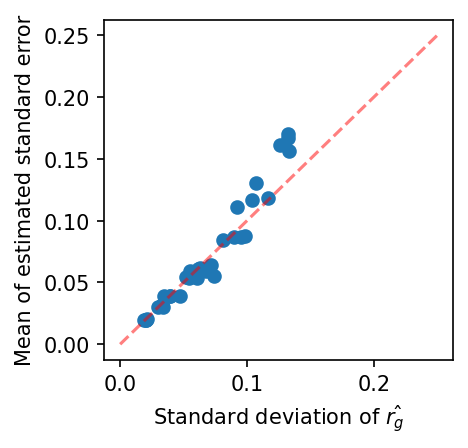

In [6]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
ax.scatter(df_plot.rg_hat_std, df_plot.mean_rg_std_hat)
ax.plot([0, 0.25], [0, 0.25], "r--", alpha=0.5)
ax.set_xlabel("Standard deviation of $\hat{r_g}$")
ax.set_ylabel("Mean of estimated standard error")

# Plot likelihood ratio test

In [6]:
est["loglik"]

-8734.827

In [8]:
full_est

{'est':   Source  Variance        SE
 0  V(G1)  0.445093  0.097275
 1  V(G2)  0.439838  0.109384
 2   V(e)  0.903571  0.024088,
 'varcov':           V(G1)     V(G2)      V(e)
 V(G1)  0.009462  0.010439 -0.002091
 V(G2)  0.010439  0.011965 -0.002286
 V(e)  -0.002091 -0.002286  0.000580,
 'loglik': -8734.827,
 'n': 17299}

In [10]:
reduced_est

NameError: name 'reduced_est' is not defined

In [48]:
df_plot = []

for hsq in [0.25]:
    #     for pcausal in [0.0001, 0.001, 0.01, 1.0]:
    for pcausal in [1.0]:
        for cor in [0.8]:
            for hermodel in ["mafukb"]:
                for sim_i in range(100):
                    full_f_name = (
                        f"out/gcta-estimate/hsq-{hsq}-pcausal-{pcausal}-cor-{cor}"
                        + f"-hermodel-{hermodel}.sim_{sim_i}"
                    )
                    reduced_f_name = (
                        f"out/gcta-estimate/hsq-{hsq}-pcausal-{pcausal}-cor-{cor}"
                        + f"-hermodel-{hermodel}.sim_{sim_i}.reduced"
                    )
                    if not os.path.exists(full_f_name + ".hsq") or not os.path.exists(
                        reduced_f_name + ".hsq"
                    ):
                        continue
                    full_loglik = admix.tools.gcta.read_reml(full_f_name)["loglik"]
                    reduced_loglik = admix.tools.gcta.read_reml(reduced_f_name)[
                        "loglik"
                    ]
                    df_plot.append(
                        [
                            hsq,
                            cor,
                            pcausal,
                            hermodel,
                            full_loglik,
                            reduced_loglik,
                            sim_i,
                        ]
                    )
df_plot = pd.DataFrame(
    df_plot,
    columns=[
        "hsq",
        "cor",
        "pcausal",
        "hermodel",
        "full_loglik",
        "reduced_loglik",
        "sim_i",
    ],
)

# df_plot = df_plot[df_plot.estimated_ratio_stderr < 0.3]
# fig, axes = plt.subplots(figsize=(5, 2.3), dpi=150, sharex=True, sharey=True, ncols=3)

# for ax_i, hsq in enumerate([0.1, 0.25, 0.5]):
#     df_tmp = df_plot[(df_plot.hsq == hsq)].copy()

#     ax = axes[ax_i]

#     sns.pointplot(
#         data=df_tmp,
#         x="cor",
#         y="estimated_ratio",
#         hue="pcausal",
#         ax=ax,
#         markers=".",
#         dodge=0.3,
#         join=False,
#     )
#     cor_list = sorted(df_plot.cor.unique())

#     ax.hlines(
#         cor_list,
#         np.arange(len(cor_list)) - 0.2,
#         np.arange(len(cor_list)) + 0.2,
#         color="red",
#         ls="--",
#         zorder=10,
#     )
#     ax.set_ylim(0.2, 1.3)
#     ax.set_xlabel("Simulated $r_g$")
#     ax.set_ylabel("Estimated $r_g$")
#     ax.set_title("$h_g^2$" + f" = {hsq}")
#     if ax_i != 0:
#         axes[ax_i].legend([], [], frameon=False)

In [50]:
scipy.stats.kstest(
    2 * (df_plot["full_loglik"] - df_plot["reduced_loglik"]), scipy.stats.chi2(1).cdf
)

KstestResult(statistic=0.9815427665934405, pvalue=8.273521910658877e-174)

(array([ 2., 15., 13., 30., 19.,  7.,  6.,  5.,  1.,  2.]),
 array([ 0.973 ,  3.9604,  6.9478,  9.9352, 12.9226, 15.91  , 18.8974,
        21.8848, 24.8722, 27.8596, 30.847 ]),
 <BarContainer object of 10 artists>)

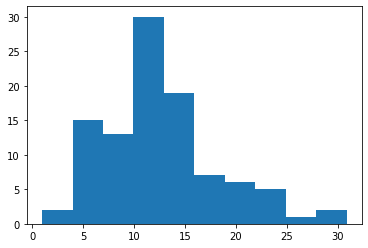

In [51]:
plt.hist(df_plot["full_loglik"] - df_plot["reduced_loglik"])

# Plot HE regression

In [ ]:
# rls_list = []

# for hsq in [0.1, 0.5]:
#     for pcausal in [0.01, 0.001, 1.0]:
#         for cor in [0.8, 1.0]:
#             for hermodel in ["mafukb"]:
#                 f_name = (
#                     f"out/estimate/hsq-{hsq}-pcausal-{pcausal}-cor-{cor}"
#                     + f"-hermodel-{hermodel}.estimate.json"
#                 )
#                 if not os.path.exists(f_name):
#                     continue
#                 with open(f_name) as f:
#                     data = json.load(f)

#                     df_tmp = pd.DataFrame(
#                         np.array([d["estimate"] for d in data]),
#                         columns=[
#                             "estimated_var_g",
#                             "estimated_rho",
#                             "estimated_var_e",
#                         ],
#                     )
#                     df_tmp["hsq"] = hsq
#                     df_tmp["cor"] = cor
#                     df_tmp["pcausal"] = pcausal
#                     df_tmp["hermodel"] = hermodel
#                     rls_list.append(df_tmp)

# df_plot = pd.concat(rls_list)
# df_plot["estimated_ratio"] = df_plot["estimated_rho"] / df_plot["estimated_var_g"]

# fig, axes = plt.subplots(figsize=(5, 2.3), dpi=150, sharex=True, sharey=True, ncols=2)

# for ax_i, hsq in enumerate([0.1, 0.5]):
#     df_tmp = df_plot[(df_plot.hsq == hsq)].copy()

#     ax = axes[ax_i]

#     sns.pointplot(
#         data=df_tmp,
#         x="cor",
#         y="estimated_ratio",
#         hue="pcausal",
#         ax=ax,
#         markers=".",
#         dodge=0.2,
#         join=False,
#     )
#     cor_list = sorted(df_plot.cor.unique())

#     ax.hlines(
#         cor_list,
#         np.arange(len(cor_list)) - 0.2,
#         np.arange(len(cor_list)) + 0.2,
#         color="red",
#         ls="--",
#         zorder=10,
#     )
#     ax.set_ylim(0.2, 1.3)
#     ax.set_xlabel("Simulated $r_g$")
#     ax.set_ylabel("Estimated $r_g$")
#     ax.set_title("$h_g^2$" + f" = {hsq}")
#     if ax_i != 0:
#         axes[ax_i].legend([], [], frameon=False)